# Investigating the Graviton!
This notebook expands on the code in the <a href="https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/blob/master/13-TeV-examples/uproot_python/GravitonAnalysis.ipynb"> Graviton Analysis</a> notebook by ATLAS, adding new cuts and sections.

This analysis loosely follows the search for a ZZ resonance by ATLAS <a href="https://link.springer.com/article/10.1140%2Fepjc%2Fs10052-018-5686-3">found here</a>.

This analysis is documented in the paper "Using ATLAS Data to Investigate Quantum Gravity and the Graviton" by Anoushka Bhattacharya, Charlie Burgoyne, Daniya Al Kindi and Tyler Hargreaves

<a id='contents'></a>

## Contents: 


[Preparation](#setup_computer) <br />

[1. Importing Packages](#set_up_everytime) <br />

[2. Luminosity, fraction and file path settings](#fraction) <br />

[3. Dictionary of samples](#samples) <br />

[4. Defining functions](#functions) <br />

[5. Defining cuts ](#cut) <br />

[6. Applying cuts](#apply) <br />

[7. Processing](#process) <br />

[8. Plotting](#plotting) <br />

<a id='setup_computer'></a>

## Preparation

This code downloads modules needed for the code to run..

In [ ]:
import yaml
import subprocess
import sys

environment_file = ".../environment.yaml" # add your pathway to your yaml file

# Packages you want to install
required_packages = ['uproot', 'pandas', 'numpy', 'matplotlib']

# Load the environment.yml file
with open(environment_file, 'r') as file:
    environment_data = yaml.safe_load(file)

# Extract dependencies
dependencies = environment_data.get('dependencies', [])

# Create a list to hold the packages with versions
install_packages = []

# Find the versions for the required packages
for dep in dependencies:
    # Check if the dependency is a string (package name)
    if isinstance(dep, str):
        for package in required_packages:
            if dep.startswith(package):
                install_packages.append(dep)

# Install packages 
if install_packages:
    print(f"Installing packages: {install_packages}")
    subprocess.run([sys.executable, "-m", "pip", "install", "--upgrade", "--user"] + install_packages)
else:
    print("No matching packages found in environment.yml.")

Installing packages: ['numpy', 'pandas', 'matplotlib']


[Back to contents](#contents)

<a id='set_up_everytime'></a>

## 1. Importing Packages


We're going to be using a number of tools to help us:

* uproot: lets us read .root files typically used in particle physics into data formats used in python

* pandas: lets us store data as dataframes, a format widely used in python

* numpy: provides numerical calculations such as histogramming

* matplotlib: common tool for making plots, figures, images, visualisations


In [ ]:
import uproot # for reading .root files
import awkward as ak # added to improve how data is stored
import pandas as pd # to store data as dataframe
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import AutoMinorLocator,LogLocator,LogFormatterSciNotation # for minor ticks

import infofile # local file containing cross-sections, sums of weights, dataset IDs

[Back to contents](#contents)

<a id='fraction'></a>

## 2. Luminosity, fraction and filepath settings

In [ ]:
#lumi = 0.5 # fb-1 # data_A only
#lumi = 1.9 # fb-1 # data_B only
#lumi = 2.9 # fb-1 # data_C only
#lumi = 4.7 # fb-1 # data_D only
lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

fraction = 0.1 # reduce this is you want the code to run quicker
                                                                                                                                  
#tuple_path = "Input/4lep/" # local 
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/" # web address


[Back to contents](#contents)

<a id='samples'></a>

## 3. Dictionary of samples

This dictionary of samples to process contains prefixes and filepaths so we can make filestrings to access Open Data ATLAS files.

In [4]:
samples = {

    'data': {
        'list' : ['data_A','data_B','data_C','data_D']
    },
    
    r'$Z,t\bar{t}$' : { # Z + ttbar
        'list' : ['Zee','Zmumu','ttbar_lep'],
        'color' : "#6b59d3" # purple
    },
    
    r'$t\bar{t}V$' : { # ttV
        'list' : ['ttW','ttee','ttmumu'], # ttW, ttZ(->ee), ttZ(->mm)
        'color' : "#f0f423" # yellow
    },
    
    'ZZ' : { # ZZ->llll
        'list' : ['llll'],
        'color' : "#ff0000" # red
    },
    
    'Graviton' : {
        'list' : ['RS_G_ZZ_llll_c10_m0500'], # mG = 500 GeV
        'color' : "#baff8d" # green
    },

}

[Back to contents](#contents)

<a id='functions'></a>

## 4. Defining Functions


Define function to get data from files

The datasets used in this notebook have already been filtered to include at least 4 leptons per event, so that processing is quicker.

In [5]:
def get_data_from_files():

    data = {} # define empty dictionary to hold dataframes
    for s in samples: # loop over samples
        print('Processing '+s+' samples') # print which sample
        frames = [] # define empty list to hold data
        for val in samples[s]['list']: # loop over each file
            if s == 'data': prefix = "Data/" # Data prefix
            else: # MC prefix
                prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".4lep.root" # file name to open
            temp = read_file(fileString,val) # call the function read_file defined below
            frames.append(temp) # append dataframe returned from read_file to list of dataframes
        data[s] = pd.concat(frames) # dictionary entry is concatenated dataframes
    
    return data # return dictionary of dataframes

[Back to contents](#contents)

Define function to calculate:
* weight of MC event

* cross-section weight

* 4-lepton invariant mass

* transverse momementum in all dimensions

* 2-lepton invariant mass


In [6]:
def calc_weight(xsec_weight, mcWeight, pileup, ele, muon, trigger):
    return xsec_weight * mcWeight * pileup * ele * muon * trigger


def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight =(lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight



def calc_mllll(lep_pt, lep_eta, lep_phi, lep_E):
    px = lep_pt*np.cos(lep_phi)
    py = lep_pt*np.sin(lep_phi)
    pz = lep_pt * np.sinh(lep_eta)
    E =lep_E

    px_sum =ak.sum(px, axis=1)
    py_sum = ak.sum(py, axis=1)
    pz_sum= ak.sum(pz, axis=1)
    E_sum = ak.sum(E, axis=1)

    return np.sqrt(E_sum**2 - px_sum**2 - py_sum**2 - pz_sum**2) / 1000  # GeV


def calc_p(lep_pt, lep_eta, lep_phi):
    px = lep_pt*np.cos(lep_phi)
    py = lep_pt*np.sin(lep_phi)
    pz = lep_pt * np.sinh(lep_eta)

    p=[px, py, pz]

    return p

def calc_mll(p1, p2, E1, E2): 
    p_squared= (p1[0] + p2[0])**2 + (p1[1] + p2[1])**2 + (p1[2] + p2[2])**2
    E_squared = (E1 + E2)**2

    return (np.sqrt(E_squared - p_squared)/1000)

[Back to contents](#contents)

<a id='cut'></a>

## 5. Defining cuts

This is the basis for which we decide whether to keep or discard events. 
Returns false if we don't need to make the cut.

.



### a.) Cut on lepton charge

Citation: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"

In [7]:
def cut_lep_charge(lep_charge):
    try:
        charge = lep_charge[0][0] + lep_charge[0][1] + lep_charge[0][2] + lep_charge[0][3]
    except:
        return True
    
    if charge == 0:
        return False
    else: 
        return True 

[Back to contents](#contents)

### b.)  Cut on lepton type

Citation: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge" 

Adapted to include ensuring the pairs of like leptons are also oppositely charged

In [8]:
def cut_lep_type(lep_type, lep_charge):
    try:
        lep1 = [lep_charge[0][0], lep_type[0][0]]
    except:
        return True
    
    
    lep2 = [lep_charge[0][1], lep_type[0][1]]
    lep3 = [lep_charge[0][2], lep_type[0][2]]
    lep4 = [lep_charge[0][3], lep_type[0][3]]

    leps=[lep1, lep2, lep3, lep4]
    e = 0
    m = 0
    mcharge = 0
    echarge = 0


    for lep in leps:
        if lep[1]==11:
            echarge += lep[0]  
            e+=1
        elif lep[1]==13:
            mcharge += lep[0] 
            m+=1

    condition1 = mcharge + echarge != 0
    condition2 = ((e%2) + (m%2) != 0) 

    return condition1 or condition2


[Back to contents](#contents)

### c.)  Cut on 2-lepton invariant mass

First the 4 leptons are paired and the pair with a mass closest to 91.2 GeV (the mass of the Z boson) is the lead pair which should have a mass within the range of 76 to 106 GeV. The second pair have a different range: their lower bound is the 4 lepton invariant mass multiplied by 0.74 with 94.4 subtracted from it (0.74 x mllll - 94.4) GeV and the upper bound is 115 GeV. If 4 lepton invariant mass is bigger than 190, it is set equal to 190 or if it is less than 140, it is set equal to 140. 

In [9]:
def cut_lep_mass(lep_type, lep_charge, lep_pt, lep_eta, lep_phi,lep_E):
    # puts each lepton into an array of its properties
    try:
        lep1 = [lep_type[0][0], lep_charge[0][0], lep_pt[0][0], lep_eta[0][0], lep_phi[0][0],lep_E[0][0]]
    except:
        return True
    
    lep2 = [lep_type[0][1], lep_charge[0][1], lep_pt[0][1], lep_eta[0][1], lep_phi[0][1],lep_E[0][1]]
    lep3 = [lep_type[0][2], lep_charge[0][2], lep_pt[0][2], lep_eta[0][2], lep_phi[0][2],lep_E[0][2]]
    lep4 = [lep_type[0][3], lep_charge[0][3], lep_pt[0][3], lep_eta[0][3], lep_phi[0][3],lep_E[0][3]]


    # sort into positive and negative leptons
    pos = []
    neg = []
    leps=[lep1, lep2, lep3, lep4]

    for lep in leps:
        if lep[1]==-1:
            neg.append(lep)
        else:
            pos.append(lep)

    # p for pos, n for neg, two positives, two negatives, each have their properties
    p1_p = calc_p(pos[0][2], pos[0][3], pos[0][4])
    p1_pt= pos[0][2]
    p1_eta = pos[0][3]
    p1_phi = pos[0][4]
    p1_E = pos[0][5]

    p2_p= calc_p(pos[1][2], pos[1][3], pos[1][4])
    p2_pt= pos[1][2]
    p2_eta = pos[1][3]
    p2_phi = pos[1][4]
    p2_E= pos[1][5]

    n1_p= calc_p(neg[0][2], neg[0][3], neg[0][4])
    n1_pt= neg[0][2]
    n1_eta = neg[0][3]
    n1_phi = neg[0][4]
    n1_E= neg[0][5]

    n2_p= calc_p(neg[1][2], neg[1][3], neg[1][4])
    n2_pt= neg[1][2]
    n2_eta = neg[1][3]
    n2_phi = neg[1][4]
    n2_E= neg[1][5]
    

    # calculating 4-lepton invariant mass
    pt =[[p1_pt, p2_pt, n1_pt, n2_pt]]
    eta = [[p1_eta, p2_eta, n1_eta, n2_eta]]
    phi = [[p1_eta, p2_eta, n1_eta, n2_eta]]
    E= [[p1_E, p2_E, n1_E, n2_E]]

    mllll= calc_mllll(pt,eta,phi,E)

    # calculates 2-lepton invariant mass of all different possibilities of pairs, this is equivalent to the mass of a Z boson
    masses = [calc_mll(p1_p, n1_p, p1_E, n1_E), calc_mll(p2_p, n2_p, p2_E, n2_E) ,calc_mll(p2_p, n1_p, p2_E, n1_E), calc_mll(p1_p, n2_p, p1_E, n2_E)]

    # find mass of the pair closest to 91.2 GeV (the mass of the Z boson)
    diff=0
    closest=0
    lowest_diff= abs(masses[0]-91.2)
    for i in range(0,4):
        diff= abs(masses[i]-91.2)
        if diff<lowest_diff:
            lowest_diff=diff
            closest=i

    # closest pair is Z Boson 1 while the other pair in its set is Z Boson 2
    match closest:
        case 0:
            Z1= masses[0]
            Z2= masses[1]
        case 1:
            Z1= masses[1]
            Z2= masses[0]
        case 2:
            Z1= masses[2]
            Z2= masses[3]
        case 3:
            Z1= masses[3]
            Z2= masses[2]

    # calculate lower bound for Z2 using mllll
    if mllll>190:
        mllll=190

    if mllll<140:
        mllll=140

    lower_bound= (0.76*mllll) - 94.4


    if Z1>106 or Z1<50 or Z2>115 or Z2<lower_bound:
        return True
    else:
        return False

### d.)  Cut on transverse momentum

All electrons must have pT > 7 GeV, while muons must have pT > 5 GeV. The lepton with the greatest transverse momentum must have pT > 20 GeV, while the second must have pT > 15 GeV and the third pT > 10 GeV.


In [10]:
def cut_lep_Pt(lep_charge, lep_pt, lep_type): 
    try:
        lep1 = [lep_charge[0][0], lep_pt[0][0]/1000, lep_type[0][0]]
    except:
        return True
    
    lep2 = [lep_charge[0][1], lep_pt[0][1]/1000, lep_type[0][1]]
    lep3 = [lep_charge[0][2], lep_pt[0][2]/1000, lep_type[0][2]]
    lep4 = [lep_charge[0][3], lep_pt[0][3]/1000, lep_type[0][3]]

    leps=[lep1, lep2, lep3, lep4]

    for lep in leps:
        if lep[2]==11 and lep[2]<7:
            return True
        elif lep[2]==13 and lep[2]<5:
            return True

    p = np.array([lep1[1], lep2[1], lep3[1], lep4[1]])
    p= np.sort(p)
    
    if p[3]>20 and p[2]>15 and p[1]>10:
        return False
    else:
        return True


### e.)  Cut on angle seperation

The two leptons in a pair must have angular separation, ∆ R, greater than 0.2

In [11]:
def cut_lep_separation(lep_charge, lep_eta, lep_phi):
    try:
        lep1 = [lep_charge[0][0], lep_eta[0][0], lep_phi[0][0]]
    except:
        return True
    
    lep2 = [lep_charge[0][1], lep_eta[0][1], lep_phi[0][1]]
    lep3 = [lep_charge[0][2], lep_eta[0][2], lep_phi[0][2]]
    lep4 = [lep_charge[0][3], lep_eta[0][3], lep_phi[0][3]]
    
    pos = []
    neg = []
    leps=[lep1, lep2, lep3, lep4]


    for lep in leps:
        if lep[0]==-1:
            neg.append(lep)
        else:
            pos.append(lep)
    separation_cuts = []
    for pos_lep in pos:
        for neg_lep in neg:
            delta_eta = pos_lep[1] - neg_lep[1]
            delta_phi = pos_lep[2] - neg_lep[2]
            separation_cuts.append((math.sqrt(delta_eta**2 + delta_phi**2) < 0.2))
    if False in separation_cuts:
        return False
    else:
        return True

<a id='apply'></a>

## 6. Applying cuts

This function:

* Reads the file

* Extracts the data we want and organises it in a dataframe

* Applies cuts and removes unwanted events from the dataframe

In [12]:
def read_file(path, sample):
    start = time.time()
    print("\tProcessing:", sample)

    tree = uproot.open(path)["mini"]
    numevents = tree.num_entries

    data_all = []

    if 'data' not in sample:
        xsec_weight = get_xsec_weight(sample)

    for data in tree.iterate([ 'lep_n',
        'lep_pt','lep_eta','lep_phi','lep_E',
        'lep_charge','lep_type', 
        'mcWeight','scaleFactor_PILEUP',
        'scaleFactor_ELE','scaleFactor_MUON',
        'scaleFactor_LepTRIGGER'
    ], library="ak", entry_stop=numevents*fraction):

        nIn = len(data)
        
        if 'data' not in sample:
            data["totalWeight"] = (
                xsec_weight * data["mcWeight"] *
                data["scaleFactor_PILEUP"] *
                data["scaleFactor_ELE"] *
                data["scaleFactor_MUON"] *
                data["scaleFactor_LepTRIGGER"]
            )

        # Apply charge cut
        charge_mask = []
        for i in range(len(data)):
            mask_val1= cut_lep_charge(data["lep_charge"][i:i+1])
            charge_mask.append(not(mask_val1))  # Keep events that do NOT fail the cut

        charge_mask = ak.Array(charge_mask)
        data = data[charge_mask]


        # Apply type cut
        if len(data)!=0:
            type_mask = []
            for i in range(len(data)):
                mask_val2 = cut_lep_type(data["lep_type"][i:i+1], data["lep_charge"][i:i+1])
                type_mask.append(not(mask_val2))  # Keep events that do NOT fail the cut

            type_mask = ak.Array(type_mask)
            data = data[type_mask]


    
        # Apply mass cut
        if len(data)!=0:
            mass_mask = []
            for i in range(len(data)):
                mask_val= cut_lep_mass( data["lep_type"][i:i+1], data["lep_charge"][i:i+1], data["lep_pt"][i:i+1], data["lep_eta"][i:i+1],data["lep_phi"][i:i+1],data["lep_E"][i:i+1])
            
                mass_mask.append(not(mask_val))  # Keep events that do NOT fail the cut

            mass_mask = ak.Array(mass_mask)
            data = data[mass_mask]
            
        
        # Apply transverse momentum cut
        if len(data)!=0:
            pT_mask = []
            for i in range(len(data)):
                mask_value = cut_lep_Pt(data["lep_charge"][i:i+1], data["lep_pt"][i:i+1], data["lep_type"][i:i+1])
                pT_mask.append(not(mask_value))
            pT_mask = ak.Array(pT_mask)
            data = data[pT_mask]
        
        # Apply seperation cut
        if len(data)!=0:
            sep_mask = []
            for i in range(len(data)):
                mask_value1 = cut_lep_separation(data["lep_charge"][i:i+1], data["lep_eta"][i:i+1], data["lep_phi"][i:i+1])
                sep_mask.append(not(mask_value1))
            sep_mask = ak.Array(sep_mask)
            data = data[sep_mask]

        # Calculate mllll
        data["mllll"] = calc_mllll(data["lep_pt"], data["lep_eta"], data["lep_phi"], data["lep_E"])

        nOut = len(data)
        data_all.append(data)

        elapsed = time.time() - start
        print(f"\t\t nIn: {nIn},\t nOut: {nOut}\t in {round(elapsed,1)}s")

    # Combine all chunks
    data_final = ak.concatenate(data_all)

    # Convert to pandas for downstream usage
    df = ak.to_dataframe(data_final)

    return df

[Back to contents](#contents)

<a id='process'></a>

## 7. Processing

This is where the processing happens (this will take some minutes)

In [13]:
start = time.time() # time at start of whole processing
data = get_data_from_files() # process all files
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Processing data samples
	Processing: data_A
		 nIn: 1,	 nOut: 0	 in 0.4s
		 nIn: 1,	 nOut: 1	 in 0.5s
		 nIn: 1,	 nOut: 0	 in 0.5s
		 nIn: 1,	 nOut: 0	 in 0.5s
		 nIn: 1,	 nOut: 1	 in 0.5s
		 nIn: 1,	 nOut: 1	 in 0.5s
		 nIn: 1,	 nOut: 0	 in 0.5s
		 nIn: 1,	 nOut: 0	 in 0.5s
		 nIn: 1,	 nOut: 1	 in 0.5s
		 nIn: 1,	 nOut: 0	 in 0.5s
		 nIn: 1,	 nOut: 0	 in 0.5s
		 nIn: 1,	 nOut: 0	 in 0.5s
		 nIn: 1,	 nOut: 0	 in 0.5s
		 nIn: 1,	 nOut: 0	 in 0.5s
		 nIn: 1,	 nOut: 0	 in 0.6s
		 nIn: 1,	 nOut: 1	 in 0.6s
		 nIn: 1,	 nOut: 1	 in 0.6s
		 nIn: 1,	 nOut: 1	 in 0.6s
		 nIn: 1,	 nOut: 0	 in 0.6s
	Processing: data_B
		 nIn: 1,	 nOut: 1	 in 0.2s
		 nIn: 1,	 nOut: 1	 in 0.3s
		 nIn: 1,	 nOut: 1	 in 0.3s
		 nIn: 1,	 nOut: 0	 in 0.3s
		 nIn: 1,	 nOut: 0	 in 0.3s
		 nIn: 1,	 nOut: 0	 in 0.3s
		 nIn: 1,	 nOut: 0	 in 0.3s
		 nIn: 1,	 nOut: 0	 in 0.3s
		 nIn: 1,	 nOut: 0	 in 0.3s
		 nIn: 1,	 nOut: 0	 in 0.3s
		 nIn: 1,	 nOut: 0	 in 0.3s
		 nIn: 1,	 nOut: 0	 in 0.3s
		 nIn: 1,	 nOut: 1	 in 0.3s
		 nIn: 

[Back to contents](#contents)

<a id='plotting'></a>

## 8. Plotting

* Define class to display log values

* Define function to plot the data 

* Calls function to plot

<>:129: SyntaxWarning: invalid escape sequence '\s'
<>:129: SyntaxWarning: invalid escape sequence '\s'
/var/folders/3s/lzpy6zcn6k712x05yzytqfg80000gn/T/ipykernel_40423/2815077068.py:129: SyntaxWarning: invalid escape sequence '\s'
  '$\sqrt{s}$=13 TeV, '+lumi_used+' fb$^{-1}$', # text


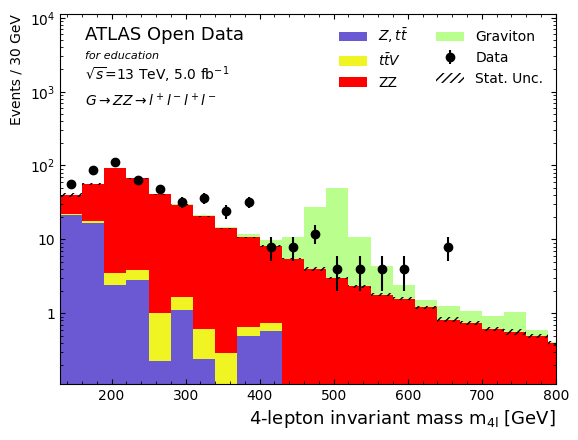

In [ ]:
# define class to display 1 and 10 normally
class CustomTicker(LogFormatterSciNotation): 
    def __call__(self, x, pos=None): 
        if x not in [1,10]: # not 1 or 10
            return LogFormatterSciNotation.__call__(self,x, pos=None)
        else: # 1 or 10
            return "{x:g}".format(x=x) # standard notation
        
def plot_data(data):

    xmin = 130 # GeV
    xmax = 1230 # GeV
    step_size = 30 # GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data['data']['mllll'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    signal_x = data['Graviton']['mllll'] # histogram the signal
    signal_weights = data['Graviton'].totalWeight # get the weights of the signal events
    signal_color = samples['Graviton']['color'] # get the colour for the signal bar

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', 'Graviton']: # if not data nor signal
            mc_x.append( data[s]['mllll'] ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])
    
    # plot the signal bar
    main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                   weights=signal_weights, color=signal_color,
                   label='Graviton')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err, color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 
    
    main_axes.set_yscale('log') # set y-scale
    smallest_contribution = mc_heights[0][0] # get smallest contribution
    smallest_contribution.sort() # sort smallest contribution
    bottom = np.amax(data_x)/1000 # set bottom limit on y-axis
    top = np.amax(data_x)*100 # set top limit on y-axis
    main_axes.set_ylim( bottom=bottom, top=top ) # y-axis limits
    main_axes.yaxis.set_major_formatter( CustomTicker() ) 
    locmin = LogLocator(base=10.0, # log base 10
                        subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9) ) # minor tick every 0.1 
    main_axes.yaxis.set_minor_locator( locmin ) # set minor ticks

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(round(lumi*fraction,2)) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV, '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.75, # y
             r'$G \rightarrow ZZ \rightarrow l^+l^-l^+l^-$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend(ncol=2, # 2 columns
                     frameon=False ) # no box around the legend
    
    return


plot_data(data)